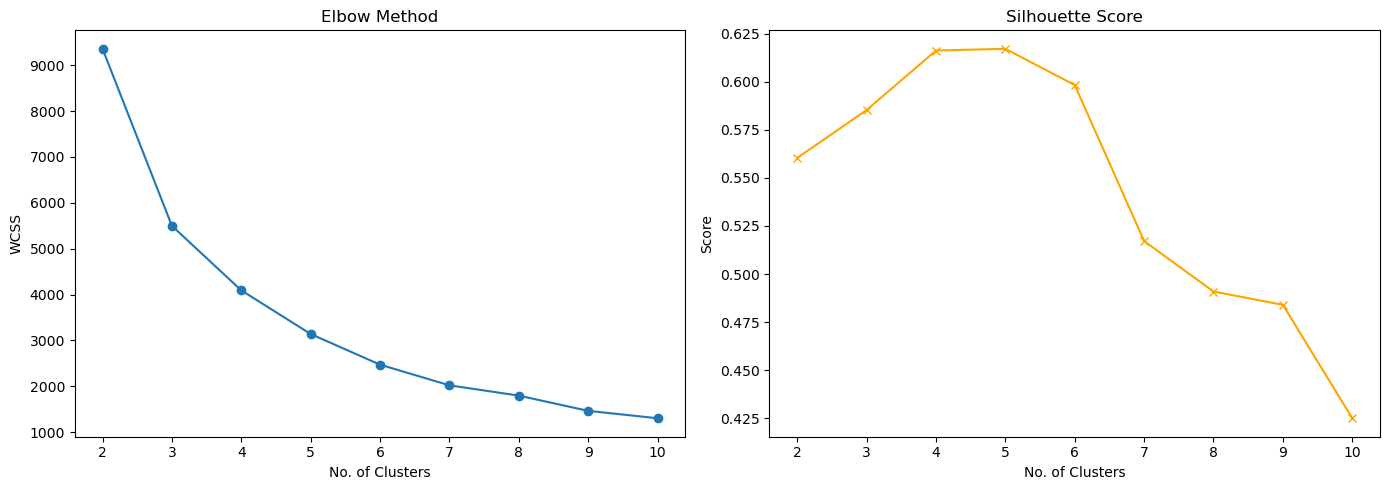

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


df=pd.read_excel('Online Retail.xlsx')

df.dropna(subset=['CustomerID'], inplace=True)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})

rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
}, inplace=True)

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

wcss = []
silhouette_scores = []
K = range(2, 11)

for k in K:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(rfm_scaled)
    wcss.append(model.inertia_)
    silhouette_scores.append(silhouette_score(rfm_scaled, model.labels_))

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(K, wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('No. of Clusters')
plt.ylabel('WCSS')

plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, marker='x', color='orange')
plt.title('Silhouette Score')
plt.xlabel('No. of Clusters')
plt.ylabel('Score')
plt.tight_layout()
plt.show()



In [12]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


Segment Profiles:
        Recency Frequency  Monetary      
           mean      mean      mean count
Cluster                                  
0          43.7       3.7    1359.0  3054
1         248.1       1.6     480.6  1067
2           7.4      82.5  127338.3    13
3          15.5      22.3   12709.1   204


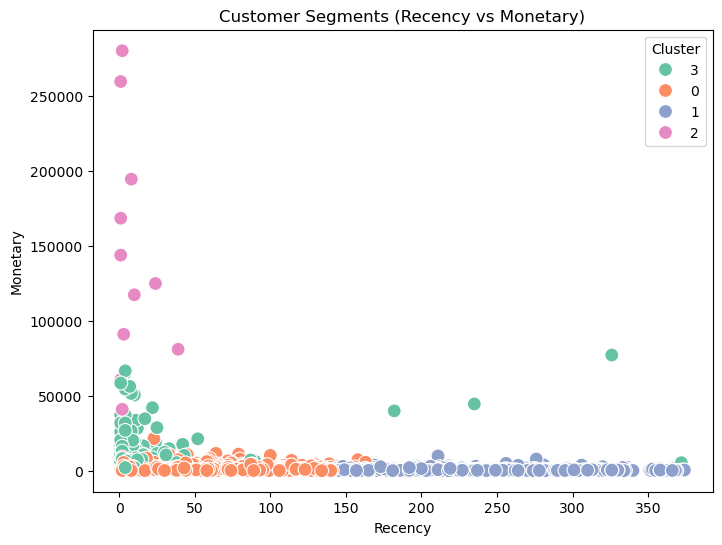

In [14]:
optimal_k = 4
final_model = KMeans(n_clusters=optimal_k, random_state=42)
rfm['Cluster'] = final_model.fit_predict(rfm_scaled)

rfm['Cluster'] = rfm['Cluster'].astype(str)
rfm_grouped = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)

print("Segment Profiles:")
print(rfm_grouped)

plt.figure(figsize=(8, 6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='Set2', s=100)
plt.title("Customer Segments (Recency vs Monetary)")
plt.show()




In [22]:
rfm.reset_index().to_csv("customer_segments.csv", index=False)